In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import os
import pandas as pd
import re
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import numpy as np
from pybaselines import Baseline, utils

# BEGIN LOOKING HERE

In [2]:
df_with_wavenumbers = pd.read_csv('spectra_scaled.csv')  # If it's a CSV file
df_with_wavenumbers.head()
print(df_with_wavenumbers["file_id"].unique())

['C_L01_02(Point3).h5' 'C_L01_02(Point4).h5' 'C_L01_02_AreaMap2.h5'
 'C_L01_02_LineH1(White).h5' 'C_L01_02_LineH2.h5' 'C_L01_05(Point4_5).h5'
 'C_L01_05(Point6).h5' 'C_L01_05_AreaMap2.h5'
 'C_L01_05_Medulla_AreaMap2.h5' 'HA7RF1S01_S2.h5' 'HA7RF1S01_S3.h5'
 'HA7RF1S01_S4-5.h5' 'TR40L701_S1.h5' 'TR40L701_S2.h5' 'TR40L701_S3.h5'
 'TR40L701_S4.h5' 'TR40L7_04_A4.h5' 'TR40L7_04_B1.h5' 'TR40L7_04_B2.h5'
 'TR40L7_04_B3.h5' 'TR40L7_04_B4.h5' 'TR40L901_S1.h5' 'TR40L901_S4.h5'
 'TR40L901_S6.h5']


/var/folders/vd/7bdl6rm52b33gwmzg9fnwcxc0000gn/T/ipykernel_47025/2590566823.py:1: DtypeWarning: Columns (1740,1743,1745,1747,1748,1749) have mixed types. Specify dtype option on import or set low_memory=False.
  df_with_wavenumbers = pd.read_csv('spectra_scaled.csv')  # If it's a CSV file


In [3]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
spectral_columns = [col for col in df_with_wavenumbers.columns if col.replace('.', '', 1).isdigit()]
wavenumbers = np.array([float(wn) for wn in spectral_columns])


<Figure size 1200x800 with 0 Axes>

## Baseline Correction

In [4]:
def plot_spectrum(x, y, file_id, df):
    spectrum_row = df[(df['x'] == x) & (df['y'] == y) & (df['file_id'] == file_id)]
    if not spectrum_row.empty:
        spectrum = spectrum_row[spectral_columns].values.flatten()
        plt.plot(wavenumbers, spectrum, label=f'({x}, {y}), {file_id}')
        plt.xlabel('Wavenumber (cm$^{-1}$)')
        plt.ylabel('Normalized Intensity')
        plt.gca().invert_xaxis() 
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data found for coordinates ({x}, {y}) in file {file_id}")    

In [12]:
df_bc = df_with_wavenumbers.copy()

In [13]:
def update_spectrum_bc(spectrum_row, df):
    spectrum = 1 - spectrum_row[spectral_columns].values.flatten()
    baseline_fitter = Baseline(x_data=wavenumbers)
    bkg_1, params_1 = baseline_fitter.modpoly(spectrum, poly_order=3)
    spectrum_bc = spectrum - bkg_1
    spectrum_bc = spectrum_bc / np.max(spectrum_bc) 
    df.loc[spectrum_row.index, spectral_columns] = spectrum_bc

In [14]:
def subtract_baseline(file_id, df):
    df_file = df[df['file_id'] == file_id]
    for x, y in zip(df_file['x'], df_file['y']):
            spectrum_row = df_file[(df_file['x'] == x) & (df_file['y'] == y) & (df_file['file_id'] == file_id)]
            if not spectrum_row.empty:
                update_spectrum_bc(spectrum_row, df)
            else: 
                 print(f"No data found for coordinates ({x}, {y}) in file {file_id}")

In [15]:
subtract_baseline('TR40L701_S4.h5', df_bc)

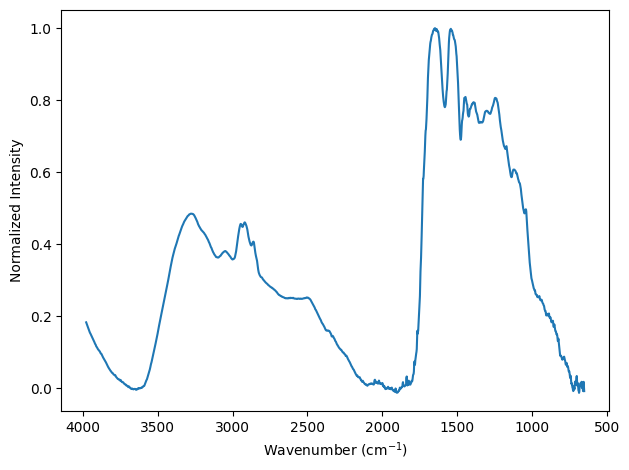

In [16]:
plot_spectrum(5, 5, 'TR40L701_S4.h5', df_bc)

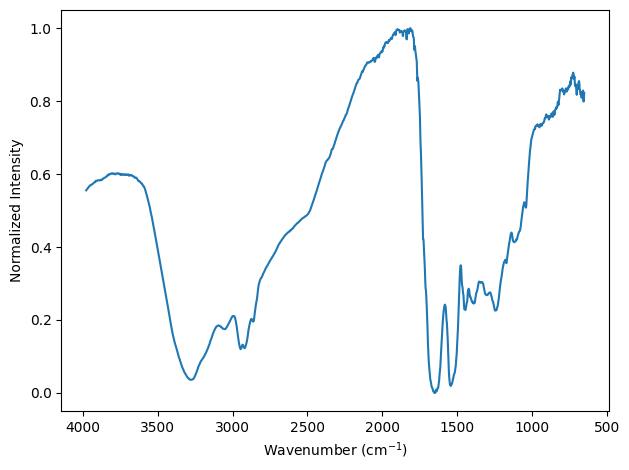

In [11]:
plot_spectrum(5, 5, 'TR40L701_S4.h5', df_with_wavenumbers)

## Background Subtraction

In [17]:
wave_949 = str(min(wavenumbers, key=lambda x: abs(x - 949)))
wave_847 = str(min(wavenumbers, key=lambda x: abs(x - 847)))

In [18]:
df_bs= df_bc.copy()

In [ ]:
def subtract_background(file_id):
    df_file = df_bc[df_bc['file_id'] == file_id]
    background_row = df_file[(df_file['x'] == 0) & (df_file['y'] == 0)]
    background_numbers = background_row[spectral_columns].values.flatten()
    background_949 = background_row[wave_949].values.flatten()
    for x, y in zip(df_file['x'], df_file['y']):
            spectrum_row = df_file[(df_file['x'] == x) & (df_file['y'] == y)]
            spectrum_numbers = spectrum_row[spectral_columns].values.flatten()
            spectrum_949 = spectrum_row[wave_949].values.flatten()
            ratio = spectrum_949 / background_949
            spectrum_bs= spectrum_numbers - background_numbers*ratio
            df_bs.loc[spectrum_row.index, spectral_columns] = spectrum_bs

In [20]:
subtract_background('TR40L701_S4.h5')

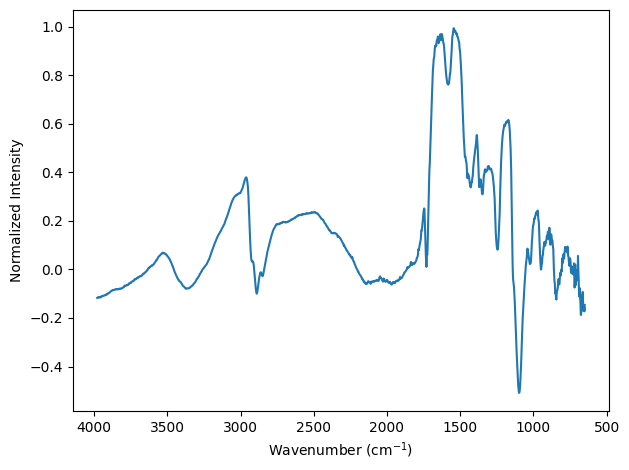

In [21]:
plot_spectrum(5, 5, 'TR40L701_S4.h5', df_bs)

In [22]:
subtract_baseline('TR40L701_S4.h5', df_bs)

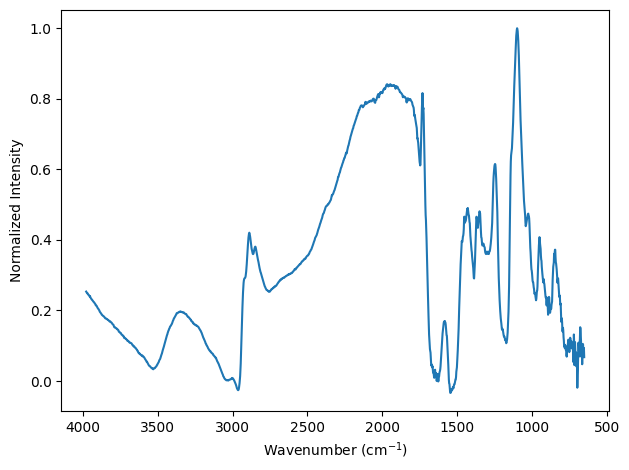

In [23]:
plot_spectrum(5, 5, 'TR40L701_S4.h5', df_bs)

## Apply to the whole dataset

In [24]:
for file_id in df_with_wavenumbers["file_id"].unique():
    df_bc = df_with_wavenumbers.copy()
    subtract_baseline(file_id, df_bc)
    subtract_background(file_id)
    subtract_baseline(file_id, df_bs)

In [26]:
df_bs.to_csv('df_bs.csv', index=False)